The purpose of the case study is to classify a given silhouette as one of four different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
Four &quot;Corgie&quot; model vehicles were used for the experiment: a double decker bus, Cheverolet
van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
 
 
The points distribution for this case is as follows:
1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)
2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)
3. Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance) - 10 points
4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy. (10 points)

https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Common Functions -- START

In [2]:
def get_high_corrleation_features(df, field, threshold):
    THRESHOLD = threshold
    s = df.corr().loc[field]
    return pd.DataFrame(s[s > THRESHOLD].sort_values(ascending=False)).iloc[1:]

In [3]:
def highlight_odd(record, kwargs):
    """
    Takes a record and returns an array of same size as record with each value in array indicating 'background-color' 
    for each column. The 'background-color' is marked as red when the given cell is found to be violating some condition.
    Pls see the code to understand the condition being checked.
    This method requires following additional parameters to be passed through kwargs:
    1. OUTLIER_LIST - A list containing index of outlier records
    2. CATEGORY - A Category like Van, Car or Bus
    3. PERCENTAGE - Percentage value like 5 or 10 indicating the cutoff percentage applied while detecting odd cells.
    """
    
    outlier_records = kwargs['OUTLIER_LIST']
    category = kwargs['CATEGORY']
    percentage = kwargs['PERCENTAGE']
    
    output = ['' for i in range(len(record))]
    
    perc_val = (record[category]['Mean'] * percentage)/100
    i = 0
    for index in outlier_records:
        if ( (record['Outlier'][index] > (record[category]['Mean'] + perc_val)) | (record['Outlier'][index] < (record[category]['Mean'] - perc_val)) ):
            output[i] = 'background-color: red'
        i += 1

    return output

In [4]:
def draw_distplot(field):
    plt.figure(figsize=(13,8))
    ax=sns.distplot(car[field],            hist=False , label='vehicle=car', color='b')
    ax=sns.distplot(bus[field],            hist=False,  label='vehicle=bus', color='r')
    ax=sns.distplot(van[field],            hist=False,  label='vehicle=van', color='g')
    ax=sns.distplot(vehicles[field],       hist=False , label='all',         color='y')
    ax.axvline(car[field].mean(),   color='b', linestyle='--', label='Mean:car')
    ax.axvline(car[field].median(), color='b', linestyle='-',  label='Median:car')
    ax.axvline(bus[field].mean(),   color='r', linestyle='--', label='Mean:bus')
    ax.axvline(bus[field].median(), color='r', linestyle='-',  label='Median:bus')
    ax.axvline(van[field].mean(),   color='g', linestyle='--', label='Mean:van')
    ax.axvline(van[field].median(), color='g', linestyle='-',  label='Median:van')
    ax.axvline(vehicles[field].mean(),   color='y', linestyle='--', label='Mean:all')
    ax.axvline(vehicles[field].median(), color='y', linestyle='-',  label='Median:all')
    plt.legend(loc="upper right")

In [5]:
def draw_boxplot(field):
    sns.boxplot('class', field, data=vehicles, order=['car', 'bus', 'van'])

In [6]:
def print_skew(field):
    print("Car = {}, Bus = {}, Van = {}".format(car[field].skew(), bus[field].skew(), van[field].skew()))

In [7]:
def print_kurt(field):
    print("Car = {}, Bus = {}, Van = {}".format(car[field].kurt(), bus[field].kurt(), van[field].kurt()))

In [8]:
def grab_outliers(dataset, field):
    z = stats.zscore(dataset[field])
    return dataset[z > 3]    

In [9]:
def grab_outliers_IQR(dataset, field):
    _, lower, upper = get_IQR(dataset, field)
    return dataset[(dataset[field] < lower) | (dataset[field] > upper)]

In [10]:
def highlight_other_features(outliers, category_df, category_label):
    d = {}

    # Add outliers dataframe to dictionary
    outliers = outliers.drop('class', axis=1, errors='ignore')
    d['Outlier'] = outliers.T

    # Prepare Reference dataframe & add to dictionary
    f1 = pd.DataFrame(category_df.mean(), columns=["Mean"])
    d[category_label] = f1

    # Consolidate both dataframes added to dictionary to create two level Index for columns (e.g. Van -> Mean)
    consolidated = pd.concat(d, axis=1, sort=False)
    
    other_parms = {}
    other_parms['CATEGORY'] = category_label
    other_parms['OUTLIER_LIST'] = outliers.index.tolist()
    other_parms['PERCENTAGE'] = CUT_OFF_PERCENTAGE
    return consolidated.style.apply(highlight_odd, axis=1, kwargs=other_parms)

In [11]:
def refresh_datasets(vehicles):
    """
    Returns car, bus, van datasets in same order after refresh from main vehicles dataset
    """
    car = vehicles[vehicles['class'] == 'car']
    bus = vehicles[vehicles['class'] == 'bus']
    van = vehicles[vehicles['class'] == 'van']
    return car, bus, van

In [12]:
def get_IQR(dataset, field):
    """
    Calculates and returns IQR, Lower Whisker and Upper Whisker
    """
    Q1 = np.quantile(dataset[field], 0.25)
    Q3 = np.quantile(dataset[field], 0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return IQR, lower, upper

## Common Functions -- END

## Global Variables -- START

In [13]:
THRESHOLD_CORR = 0.4

In [14]:
CUT_OFF_PERCENTAGE = 10

## Global Variables -- END

In [15]:
vehicles = pd.read_csv("vehicle.csv")
vehicles.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [16]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

So we have 19 columns and 846 rows. Some of the columns have a few missing values; account for which is given below:
01. circularity - 5 missing values
02. distance_circularity - 4 missing values
03. radius_ratio - 6 missing values
04. pr.axis_aspect_ratio - 2 missing values
05. scatter_ratio - 1 missing value
06. elongatedness - 1 missing value
07. pr.axis_rectangularity - 3 missing values
08. scaled_variance - 3 missing values
09. scaled_variance.1 - 2 missing values
10. scaled_radius_of_gyration - 2 missing values
11. scaled_radius_of_gyration.1 - 4 missing value
12. skewness_about - 6 missing values
13. skewness_about.1 - 1 missing value
14. skewness_about.2 - 1 missing value

In [17]:
#type(pplot)

In [18]:
vehicles['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [19]:
#vehicles['class'] = vehicles['class'].map(lambda x :  1 if x == 'car' else (2 if x == 'bus' else 3))
#vehicles['class'].value_counts()

In [20]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

In [21]:
vehicles.pivot_table(index='class', aggfunc=['mean', 'median']).T

class                                      bus         car         van
mean   circularity                   44.981308   46.035047   42.070352
       compactness                   91.591743   96.184149   90.562814
       distance_circularity          76.767442   88.878788   73.247475
       elongatedness                 40.114679   38.093458   47.939698
       hollows_ratio                191.325688  197.582751  196.145729
       max.length_aspect_ratio        7.013761    8.825175    9.713568
       max.length_rectangularity    146.701835  149.967366  145.175879
       pr.axis_aspect_ratio          63.414747   60.992991   61.261307
       pr.axis_rectangularity        20.580645   21.511682   18.575758
       radius_ratio                 165.708333  180.591549  147.176768
       scaled_radius_of_gyration    181.032407  179.613054  157.276382
       scaled_radius_of_gyration.1   77.096774   69.924883   72.778894
       scaled_variance              192.889908  197.894614  163.964646
       scaled_variance.1            448.894495  500.543326  298.201005
       scatter_ratio                170.022936  181.053738  141.537688
       skewness_about                 4.794393    7.126464    6.417085
       skewness_about.1              10.211009   15.170561    9.698492
       skewness_about.2             187.811927  189.474299  188.939698
median circularity                   44.000000   46.000000   42.000000
       compactness                   89.000000   97.000000   90.000000
       distance_circularity          72.000000   94.000000   75.000000
       elongatedness                 44.000000   36.000000   47.000000
       hollows_ratio                189.000000  198.000000  196.000000
       max.length_aspect_ratio        6.000000    9.000000    9.000000
       max.length_rectangularity    145.000000  150.000000  145.000000
       pr.axis_aspect_ratio          64.000000   61.000000   59.000000
       pr.axis_rectangularity        19.000000   22.000000   18.000000
       radius_ratio                 167.500000  186.000000  144.000000
       scaled_radius_of_gyration    176.000000  182.000000  159.000000
       scaled_radius_of_gyration.1   76.000000   70.000000   72.000000
       scaled_variance              177.000000  206.000000  164.000000
       scaled_variance.1            344.000000  512.000000  300.000000
       scatter_ratio                152.000000  185.000000  142.000000
       skewness_about                 5.000000    6.000000    6.000000
       skewness_about.1              10.000000   14.000000    9.000000
       skewness_about.2             186.000000  189.000000  188.000000

## compactness
1. Variable type: int64, continuous
2. 0 missing values
3. (average perim)**2/area

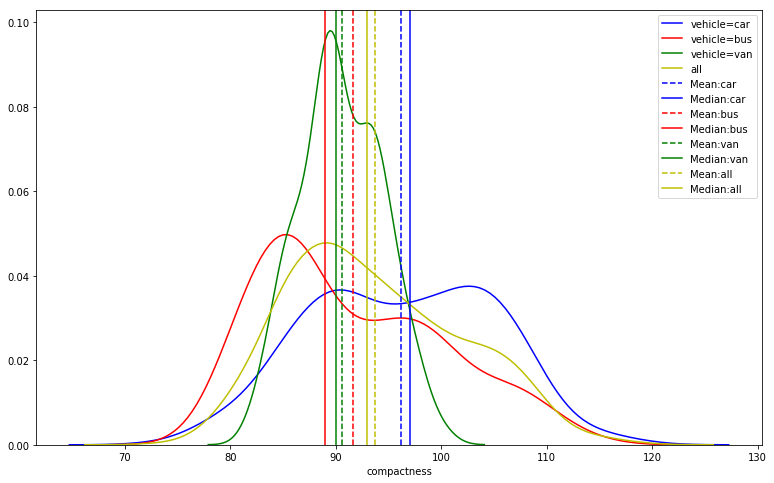

In [22]:
# Let's draw the plots
draw_distplot("compactness")

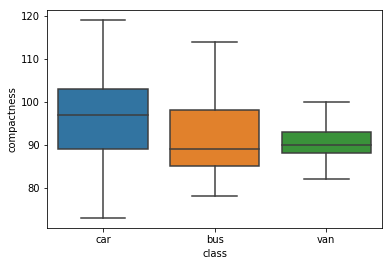

In [23]:
draw_boxplot("compactness")

In [24]:
print_skew("compactness")

Car = -0.05849050129296976, Bus = 0.5794020296284763, Van = 0.0776365608083228


In [25]:
print_kurt("compactness")

Car = -0.7158829539092375, Bus = -0.6668636424560348, Van = -0.585706415160979


1. Median compactness of van is slightly higher than bus but quite lower than car.
2. Most of the vans have very narrow range of compactness. Cars and Buses have wider range of compactness.
3. Buses have wide range of compactness in quartile 3. Infact, the upper whisker is also pretty stretched as compared lower. Buses have got right skewed distribution.
4. Cars have highest compactness and range of compactness is even too high. Both upper and lower whiskers are pretty stretched.
5. Cars have bimodal distribution with clearly two peaks visible. So in terms of compactness there should be two subgroups in cars category.
6. None of these 3 categories have got any outliers.

In [26]:
# Let's see which features are highly correlated with compactness. To do this, I am going to choose the features 
# having correlation value greater than THRESHOLD_CORR with compactness feature. 
get_high_corrleation_features(vehicles, 'compactness', THRESHOLD_CORR)
# Wov 9 other features are correlated

,compactness
scaled_variance.1,0.818674
pr.axis_rectangularity,0.814248
scatter_ratio,0.812770
distance_circularity,0.791707
scaled_variance,0.764361
radius_ratio,0.691081
circularity,0.689786
max.length_rectangularity,0.676143
scaled_radius_of_gyration,0.585845


## circularity
1. Variable type: float64, continuous
2. 5 missing values
3. (average radius)**2/area

In [27]:
# Let's first locate the records with missing values
vehicles[vehicles['circularity'].isna()]
# 4 records [Index = 5, 118, 266 & 396] are for bus & 1 record [Index = 105] is for car

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,NaN,106.0,172.0,50.0,6,255.0,26.0,28.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
105,108,NaN,103.0,202.0,64.0,10,220.0,30.0,25.0,168,NaN,711.0,214.0,73.0,11.0,NaN,188.0,199,car
118,85,NaN,NaN,128.0,56.0,8,150.0,46.0,19.0,144,168.0,324.0,173.0,82.0,9.0,14.0,180.0,184,bus
266,86,NaN,65.0,116.0,53.0,6,152.0,45.0,19.0,141,175.0,335.0,NaN,85.0,5.0,4.0,179.0,183,bus
396,108,NaN,106.0,177.0,51.0,5,256.0,26.0,28.0,170,285.0,966.0,261.0,87.0,11.0,2.0,182.0,181,bus


In [28]:
# So let's impute them with the mean values of their respective category
vehicles.loc[[5, 118, 266, 396], 'circularity'] = bus['circularity'].mean()
vehicles.loc[[105], 'circularity'] = car['circularity'].mean()

In [29]:
# Let's validate if they are all imputed properly
vehicles.loc[[5, 105, 118, 266, 396]]

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,106.0,172.0,50.0,6,255.0,26.0,28.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
105,108,46.035047,103.0,202.0,64.0,10,220.0,30.0,25.0,168,NaN,711.0,214.0,73.0,11.0,NaN,188.0,199,car
118,85,44.981308,NaN,128.0,56.0,8,150.0,46.0,19.0,144,168.0,324.0,173.0,82.0,9.0,14.0,180.0,184,bus
266,86,44.981308,65.0,116.0,53.0,6,152.0,45.0,19.0,141,175.0,335.0,NaN,85.0,5.0,4.0,179.0,183,bus
396,108,44.981308,106.0,177.0,51.0,5,256.0,26.0,28.0,170,285.0,966.0,261.0,87.0,11.0,2.0,182.0,181,bus


## ----------------- EXTRA: example to understand interpolation ------ START

In [30]:
# Simple example to understand interpolation
df = pd.DataFrame({"A":[12, 4, 5, None, 1], 
                   "B":[None, 2, 54, 3, None], 
                   "C":[20, 16, None, 3, 8], 
                   "D":[14, 3, None, None, 6]})
df

,A,B,C,D
0,12.0,NaN,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,NaN,NaN
3,NaN,3.0,3.0,NaN
4,1.0,NaN,8.0,6.0


In [31]:
df.interpolate(method ='linear', limit_direction ='forward')
# Observe 
# 0B isn't filled
# 2C filled with average of 1C & 3C
# 2D & 3D filled in intelligently in a way that 2D is average of 1D & 3D; 3D is average of 2D & 4D. Chicken and hen kind of 
# situation though.
# 3A filled with average of 2A & 4A
# 4B filled in with value of 3B

,A,B,C,D
0,12.0,NaN,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,9.5,4.0
3,3.0,3.0,3.0,5.0
4,1.0,3.0,8.0,6.0


In [32]:
df.interpolate(method ='linear', limit_direction ='backward') 

,A,B,C,D
0,12.0,2.0,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,9.5,4.0
3,3.0,3.0,3.0,5.0
4,1.0,NaN,8.0,6.0


In [33]:
df.interpolate(method ='nearest')

,A,B,C,D
0,12.0,NaN,20.0,14.0
1,4.0,2.0,16.0,3.0
2,5.0,54.0,16.0,3.0
3,5.0,3.0,3.0,6.0
4,1.0,NaN,8.0,6.0


## ----------------- EXTRA: example to understand interpolation ------ END

In [34]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

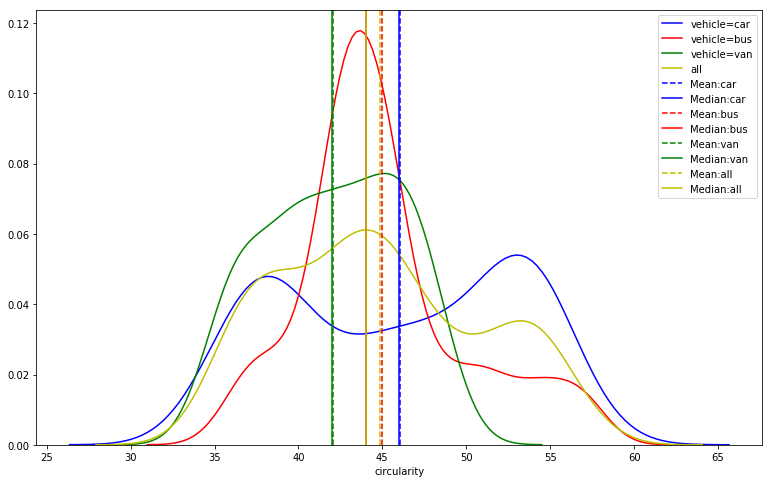

In [35]:
# Let's draw the plots
draw_distplot("circularity")

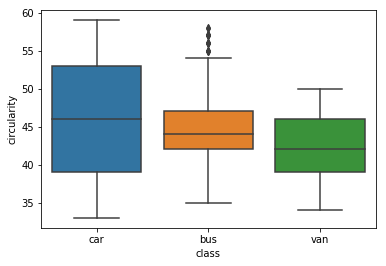

In [36]:
draw_boxplot("circularity")

In [37]:
print_skew("circularity")

Car = -0.10094782235190104, Bus = 0.772532846857724, Van = -0.12042060392646031


In [38]:
print_kurt("circularity")

Car = -1.4046123669787574, Bus = 0.4067972870820862, Van = -1.0904626704567468


1. Cars have pretty wide range of circularity. Also, circularity has bimodal distribution for cars.
2. circularity for buses is right skewed with heavy tail too. Q1 & Q4 have higher range than other quartiles.
3. Vans have lower range of circularity. Q1 has higher range than other quartiles.

In [39]:
# There are a few outliers for bus category. Using z-scores, let's see who all are outliers
outliers = grab_outliers_IQR(bus, "circularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
54,101,56.0,104.0,185.0,53.0,6,257.0,26.0,28.0,168,275.0,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,58.0,106.0,180.0,51.0,6,261.0,26.0,28.0,171,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,56.0,103.0,223.0,64.0,5,250.0,26.0,27.0,169,280.0,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
193,107,55.0,98.0,199.0,59.0,7,240.0,27.0,26.0,168,258.0,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
274,107,57.0,106.0,179.0,51.0,8,257.0,26.0,28.0,172,275.0,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
294,109,55.0,102.0,169.0,51.0,6,241.0,27.0,26.0,165,265.0,870.0,247.0,84.0,10.0,11.0,184.0,183,bus
321,113,57.0,109.0,194.0,56.0,6,260.0,26.0,28.0,175,288.0,982.0,261.0,85.0,11.0,21.0,182.0,183,bus
334,107,57.0,102.0,184.0,55.0,7,234.0,28.0,26.0,171,243.0,822.0,229.0,77.0,7.0,11.0,187.0,187,bus
531,107,55.0,103.0,167.0,49.0,7,252.0,27.0,28.0,172,269.0,904.0,239.0,83.0,5.0,30.0,179.0,186,bus
539,109,55.0,96.0,191.0,57.0,6,241.0,28.0,26.0,170,267.0,857.0,242.0,85.0,8.0,9.0,184.0,184,bus


In [40]:
# Let's replace these outlier with upper whisker
_, lower, upper = get_IQR(bus, 'circularity')
vehicles.loc[outliers.index.tolist(), 'circularity'] = upper
car, bus, van = refresh_datasets(vehicles)

In [41]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "circularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [42]:
# Let's see which features are highly correlated with circularity. 
get_high_corrleation_features(vehicles, 'circularity', THRESHOLD_CORR)
# Wov 9 other features are correlated

,circularity
max.length_rectangularity,0.963044
scaled_radius_of_gyration,0.924130
scatter_ratio,0.844539
pr.axis_rectangularity,0.840398
scaled_variance.1,0.833465
distance_circularity,0.793848
scaled_variance,0.790745
compactness,0.682360
radius_ratio,0.625217


## distance_circularity
1. Variable type: float64, continuous
2. 4 missing values
3. area/(av.distance from border)**2

In [43]:
# Let's first locate the records with missing values
vehicles[vehicles['distance_circularity'].isna()]
# 3 records [Index = 118, 207, 319] are for bus & 1 record [Index = 35] is for van

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
35,100,46.000000,NaN,172.0,67.0,9,157.0,43.0,20.0,150,170.0,363.0,184.0,67.0,17.0,7.0,192.0,200,van
118,85,44.981308,NaN,128.0,56.0,8,150.0,46.0,19.0,144,168.0,324.0,173.0,82.0,9.0,14.0,180.0,184,bus
207,85,42.000000,NaN,121.0,55.0,7,149.0,46.0,19.0,146,167.0,323.0,NaN,85.0,1.0,6.0,179.0,182,bus
319,102,51.000000,NaN,194.0,60.0,6,220.0,30.0,25.0,162,247.0,731.0,209.0,80.0,7.0,7.0,188.0,186,bus


In [44]:
# So let's impute them with the mean values of their respective category
vehicles.loc[[118, 207, 319], 'distance_circularity'] = bus['distance_circularity'].mean()
vehicles.loc[[35], 'distance_circularity'] = van['distance_circularity'].mean()

In [45]:
# Let's validate if they are correctly imputed now
vehicles.loc[[35, 118, 207, 319]]

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
35,100,46.000000,73.247475,172.0,67.0,9,157.0,43.0,20.0,150,170.0,363.0,184.0,67.0,17.0,7.0,192.0,200,van
118,85,44.981308,76.767442,128.0,56.0,8,150.0,46.0,19.0,144,168.0,324.0,173.0,82.0,9.0,14.0,180.0,184,bus
207,85,42.000000,76.767442,121.0,55.0,7,149.0,46.0,19.0,146,167.0,323.0,NaN,85.0,1.0,6.0,179.0,182,bus
319,102,51.000000,76.767442,194.0,60.0,6,220.0,30.0,25.0,162,247.0,731.0,209.0,80.0,7.0,7.0,188.0,186,bus


In [46]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

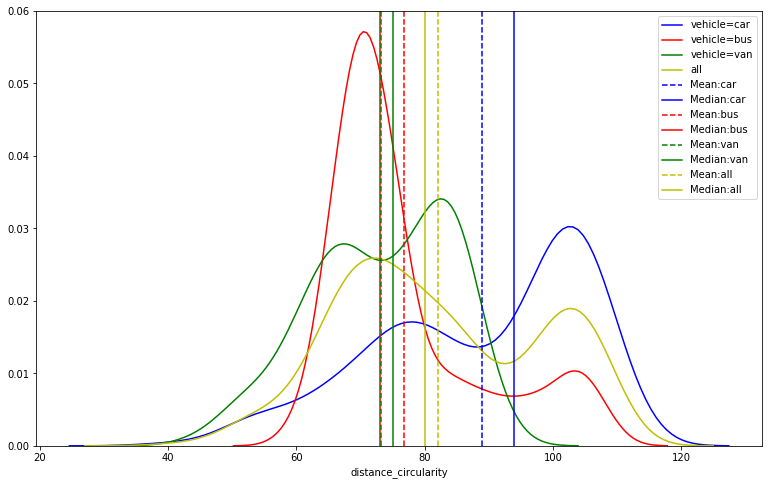

In [47]:
# Let's draw the plots
draw_distplot("distance_circularity")

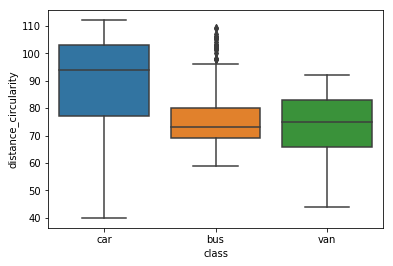

In [48]:
draw_boxplot("distance_circularity")

In [49]:
print_skew("distance_circularity")

Car = -0.632725238658727, Bus = 1.248009072213965, Van = -0.40761381274193237


In [50]:
print_kurt("distance_circularity")

Car = -0.6151006388095426, Bus = 0.5242883661570961, Van = -0.710921762176127


In [51]:
outliers = grab_outliers_IQR(bus, "distance_circularity")
outliers
# So got quite many outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,106.0,172.0,50.0,6,255.0,26.0,28.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
54,101,54.500000,104.0,185.0,53.0,6,257.0,26.0,28.0,168,275.0,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,54.500000,106.0,180.0,51.0,6,261.0,26.0,28.0,171,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,103.0,223.0,64.0,5,250.0,26.0,27.0,169,280.0,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,103.0,161.0,47.0,4,247.0,27.0,27.0,166,266.0,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
173,96,49.000000,98.0,187.0,59.0,6,213.0,31.0,24.0,152,228.0,680.0,210.0,77.0,8.0,28.0,188.0,189,bus
193,107,54.500000,98.0,199.0,59.0,7,240.0,27.0,26.0,168,258.0,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
274,107,54.500000,106.0,179.0,51.0,8,257.0,26.0,28.0,172,275.0,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
294,109,54.500000,102.0,169.0,51.0,6,241.0,27.0,26.0,165,265.0,870.0,247.0,84.0,10.0,11.0,184.0,183,bus
321,113,54.500000,109.0,194.0,56.0,6,260.0,26.0,28.0,175,288.0,982.0,261.0,85.0,11.0,21.0,182.0,183,bus


In [52]:
# Let's replace outliers with upper whisker
_, lower, upper = get_IQR(bus, 'distance_circularity')
vehicles.loc[outliers.index.tolist(), 'distance_circularity'] = upper
car, bus, van = refresh_datasets(vehicles)

In [53]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "distance_circularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


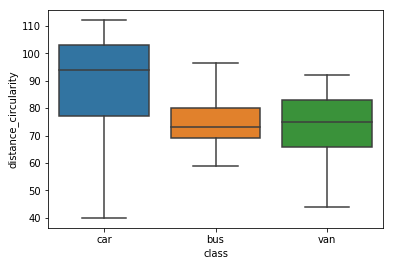

In [54]:
draw_boxplot("distance_circularity")

1. Pretty long Q1 (indicating strong left skew) for car and widest range as well. Again two peaks visible in dist plot.
2. Bus has a large peak on left and a small peak on right. Quite right skewed distribution.
3. Van has pretty wide Q1 (indicating strong left skew). Q2, Q3 & Q4 are of almost equal size.

In [55]:
# Let's see which features are highly correlated with circularity. 
get_high_corrleation_features(vehicles, 'distance_circularity', THRESHOLD_CORR)
# Wov 9 other features are correlated

,distance_circularity
scatter_ratio,0.887984
pr.axis_rectangularity,0.874112
scaled_variance.1,0.866571
scaled_variance,0.841628
circularity,0.787024
compactness,0.780304
radius_ratio,0.773823
max.length_rectangularity,0.767671
scaled_radius_of_gyration,0.686661


## radius_ratio
1. Variable type: float64, continuous
2. 6 missing values
3. (max.rad-min.rad)/av.radius

In [56]:
# Let's first locate the records with missing values
vehicles[vehicles['radius_ratio'].isna()][['radius_ratio', 'class']]
# 3 records [Index = 9, 159, 467] are for car, 2 records [Index = 78, 345] are for bus and 1 record [Index = 287] for van

,radius_ratio,class
9,NaN,car
78,NaN,bus
159,NaN,car
287,NaN,van
345,NaN,bus
467,NaN,car


In [57]:
# Let's impute them with the mean values for their corresponding class
vehicles.loc[[9, 159, 467], 'radius_ratio'] = car['radius_ratio'].mean()
vehicles.loc[[78, 345], 'radius_ratio'] = bus['radius_ratio'].mean()
vehicles.loc[[287], 'radius_ratio'] = van['radius_ratio'].mean()

In [58]:
vehicles.loc[[9, 159, 467, 78, 345, 287]][['radius_ratio', 'class']]

,radius_ratio,class
9,180.591549,car
159,180.591549,car
467,180.591549,car
78,165.708333,bus
345,165.708333,bus
287,147.176768,van


In [59]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

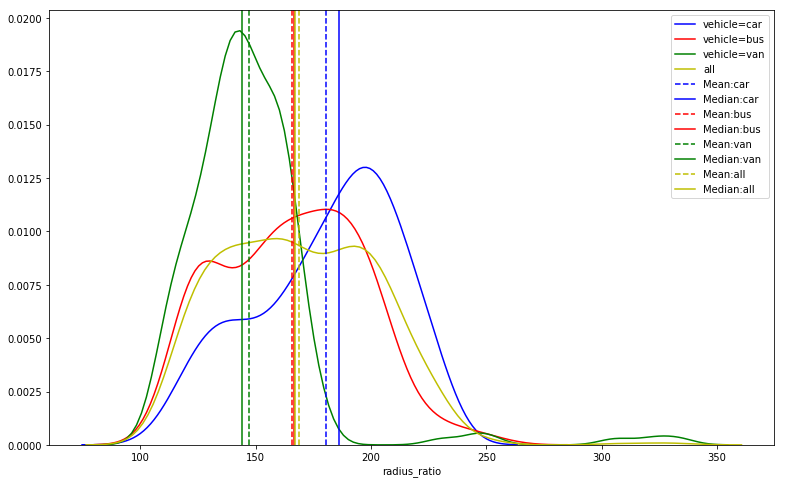

In [60]:
# Let's draw the plots
draw_distplot("radius_ratio")

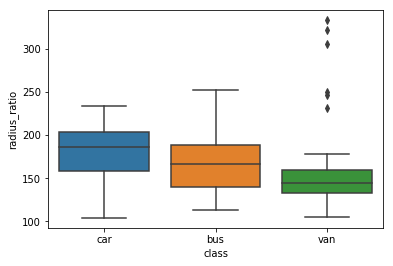

In [61]:
draw_boxplot("radius_ratio")

In [62]:
# So let's see what records are outliers
outliers = grab_outliers_IQR(van, "radius_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90,48.0,86.0,306.0,126.0,49,153.0,44.0,19.0,156,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194,van
135,89,47.0,83.0,322.0,133.0,48,158.0,43.0,20.0,163,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194,van
291,89,45.0,81.0,246.0,102.0,43,155.0,44.0,20.0,160,200.0,347.0,177.0,90.0,9.0,17.0,183.0,192,van
388,94,47.0,85.0,333.0,138.0,49,155.0,43.0,19.0,155,320.0,354.0,187.0,135.0,12.0,9.0,188.0,196,van
523,90,43.0,81.0,231.0,97.0,46,150.0,45.0,19.0,149,200.0,332.0,164.0,91.0,5.0,9.0,186.0,196,van
706,82,43.0,70.0,250.0,105.0,55,139.0,48.0,18.0,145,231.0,289.0,172.0,99.0,4.0,9.0,190.0,199,van


In [63]:
# Let's see if only radius_ratio is an outlier or the other features of these outlier records are also too far away
# from the mean of corresponding features.
# Let's check if the other features of these outliers are in 10% range (+ or - 10%) of the mean value of those features.
# A cell of outlier record is highlighted with red if it's not in 10% range of the mean value of corresponding feature.
# Like below circularity of outlier record 37 has a value of 48. The mean for this feature in VAN Category is 42.0704. 
# 10% of this mean would be 4.20704. Circularity of outlier 37 (48) is not within 10% range 
# ( Lower = 37.86336 & Upper = 46.27744). Hence it's highlighted with red background.
# This way we can highlight the remaining features of outlier 37. Eventually we see that out of 18 features, 11 features for 
# outlier 37 have been highlighted.

consolidated = highlight_other_features(outliers, van, "Van")
consolidated

In [64]:
# So not just radius_ratio, but most of the other fields for these outliers are outside the 10% range of mean values in their category (VAN).
# Ideally, one should run these records through Domain Experts to understand if such high values are some type of error 
# OR they are genuine cases. If they are genunie cases they bring in good variance to the table. 
# Since we don't have access to Domain Experts, for now I would just transform these records using upper whisker.

In [65]:
_, lower, upper = get_IQR(van, 'radius_ratio')
vehicles.loc[outliers.index.tolist(), 'radius_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [66]:
outliers = grab_outliers_IQR(van, "radius_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [67]:
# It's advised by Great Lakes Support not to reprocess the new outliers
# so not doing anything for newly popped outlier 
# https://olympus1.greatlearning.in/program_support/requests/4933

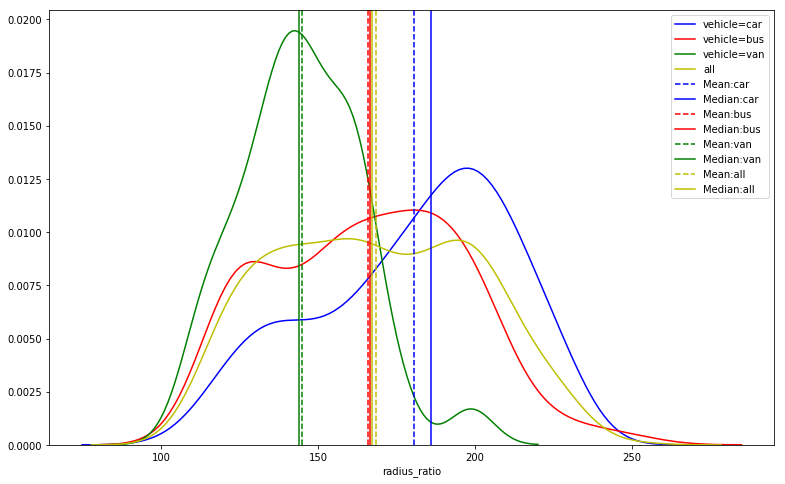

In [68]:
# Let's draw the plots
draw_distplot("radius_ratio")

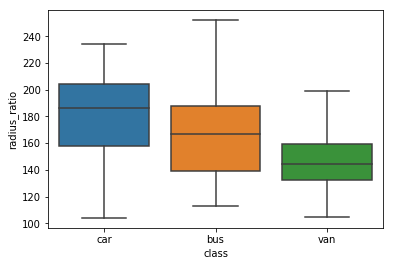

In [69]:
draw_boxplot("radius_ratio")

In [70]:
print_skew("radius_ratio")

Car = -0.44497286619721554, Bus = 0.14791541882288534, Van = 0.3637815923225437


In [71]:
print_kurt("radius_ratio")

Car = -0.7441484236670752, Bus = -0.6430776728748264, Van = 0.27902217736829993


In [72]:
# Let's see which features are highly correlated with compactness.  
get_high_corrleation_features(vehicles, 'radius_ratio', THRESHOLD_CORR)
# Wov 12 other features are correlated

,radius_ratio
distance_circularity,0.806188
scaled_variance,0.789848
scatter_ratio,0.777232
scaled_variance.1,0.764586
pr.axis_rectangularity,0.751115
compactness,0.729583
circularity,0.646882
max.length_rectangularity,0.584770
scaled_radius_of_gyration,0.557847
pr.axis_aspect_ratio,0.548111


1. radius_ratio distribution for cars is left skewed; Q1 is pretty stretched.
2. radius_ratio distribution for bus seems right skewed; Q4 is pretty stretched. It has got two peaks. Left is shorter though.
3. after transforming 5 records from Van category, radius_ratio distribution looks pretty normal. There is still skew though.
4. radius_ratio is having good correlation with many other features, which is good for dimensionality reduction.

## pr.axis_aspect_ratio
1. Variable type: float64, continuous
2. 2 missing values
3. (minor axis)/(major axis)

In [73]:
# Let's first locate the records with missing values
vehicles[vehicles['pr.axis_aspect_ratio'].isna()][['pr.axis_aspect_ratio', 'class']]
# 1 record [Index = 19] are for car & 1 record [Index = 222] are for bus

,pr.axis_aspect_ratio,class
19,NaN,car
222,NaN,bus


In [74]:
# Let's impute them with the mean values for their corresponding class
vehicles.loc[[19], 'pr.axis_aspect_ratio'] = car['pr.axis_aspect_ratio'].mean()
vehicles.loc[[222], 'pr.axis_aspect_ratio'] = bus['pr.axis_aspect_ratio'].mean()

In [75]:
# Let's validate
vehicles.loc[[19, 222]][['pr.axis_aspect_ratio', 'class']]

,pr.axis_aspect_ratio,class
19,60.992991,car
222,63.414747,bus


In [76]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

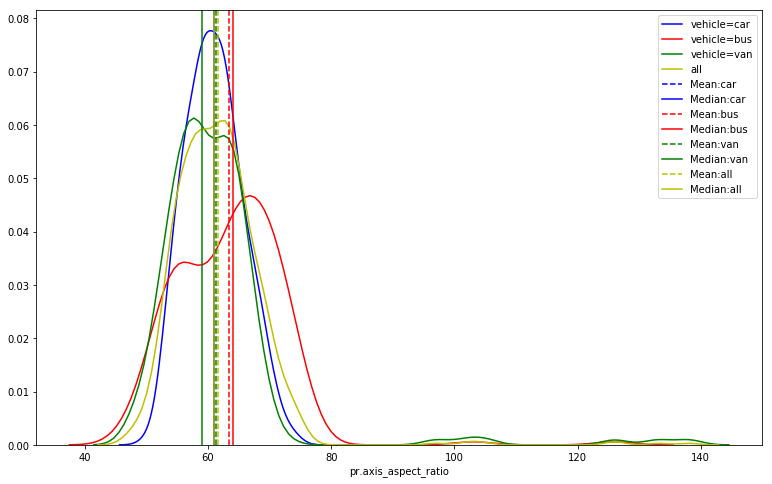

In [77]:
# Let's draw the plots
draw_distplot("pr.axis_aspect_ratio")

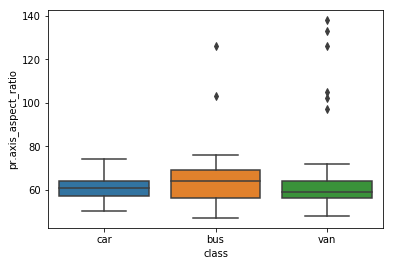

In [78]:
draw_boxplot("pr.axis_aspect_ratio")

In [79]:
print_skew("pr.axis_aspect_ratio")

Car = 0.25880171190188855, Bus = 1.8682433786195396, Van = 4.3645657005011715


In [80]:
print_kurt("pr.axis_aspect_ratio")

Car = -0.4288718074779845, Bus = 11.972165987615412, Van = 24.007144633060296


In [81]:
# Let's grab the outliers for bus
outliers = grab_outliers_IQR(bus, "pr.axis_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus
100,82,45.0,66.0,252.0,126.0,52,148.0,45.0,19.0,144,237.0,326.0,185.0,119.0,1.0,1.0,181.0,185,bus


In [82]:
# Let's assess these outliers. 
# Highlight other features that are 10% away from mean
consolidated = highlight_other_features(outliers, bus, "bus")
consolidated

In [83]:
# Let's replace them with upper whisker.
_, lower, upper = get_IQR(bus, 'pr.axis_aspect_ratio')
vehicles.loc[outliers.index.tolist(), 'pr.axis_aspect_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [84]:
# Let's check if any new outliers have popped up
outliers = grab_outliers_IQR(bus, "pr.axis_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [85]:
# Let's grab the outliers for van
outliers = grab_outliers_IQR(van, "pr.axis_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90,48.0,86.0,198.75,126.0,49,153.0,44.0,19.0,156,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194,van
135,89,47.0,83.0,198.75,133.0,48,158.0,43.0,20.0,163,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194,van
291,89,45.0,81.0,198.75,102.0,43,155.0,44.0,20.0,160,200.0,347.0,177.0,90.0,9.0,17.0,183.0,192,van
388,94,47.0,85.0,198.75,138.0,49,155.0,43.0,19.0,155,320.0,354.0,187.0,135.0,12.0,9.0,188.0,196,van
523,90,43.0,81.0,198.75,97.0,46,150.0,45.0,19.0,149,200.0,332.0,164.0,91.0,5.0,9.0,186.0,196,van
706,82,43.0,70.0,198.75,105.0,55,139.0,48.0,18.0,145,231.0,289.0,172.0,99.0,4.0,9.0,190.0,199,van


In [86]:
# Let's replace them with upper whisker.
_, lower, upper = get_IQR(van, 'pr.axis_aspect_ratio')
vehicles.loc[outliers.index.tolist(), 'pr.axis_aspect_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [87]:
# Let's check if any new outliers have popped up
outliers = grab_outliers_IQR(van, "pr.axis_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


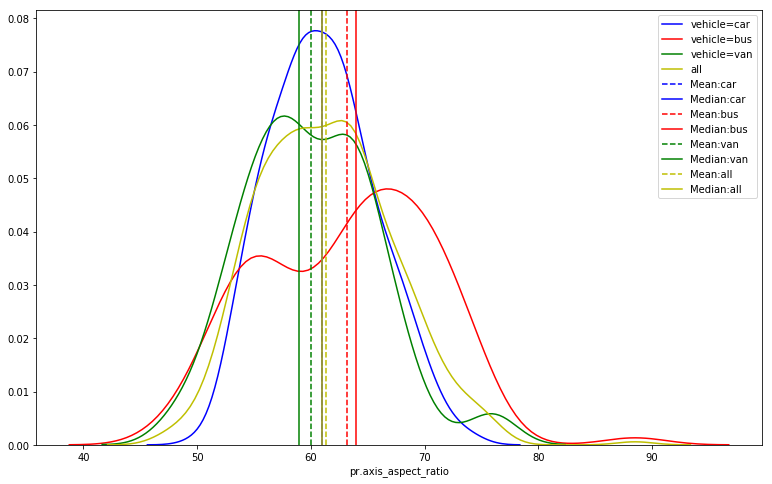

In [88]:
# Let's redraw the plots
draw_distplot("pr.axis_aspect_ratio")

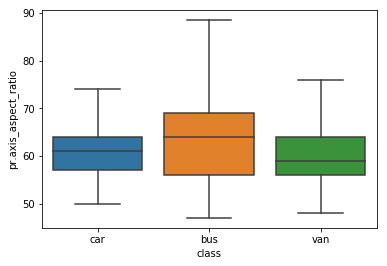

In [89]:
draw_boxplot("pr.axis_aspect_ratio")

In [90]:
get_high_corrleation_features(vehicles, "pr.axis_aspect_ratio", THRESHOLD_CORR)
# Only 1 feature is correlated

,pr.axis_aspect_ratio
radius_ratio,0.661141


## max.length_aspect_ratio
1. Variable type: int64, continuous
2. 0 missing values
3. (length perp. max length)/(max length) 

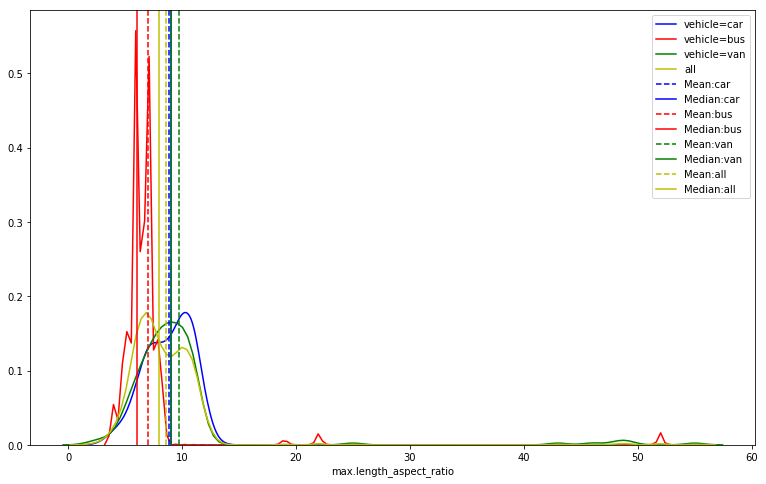

In [91]:
draw_distplot("max.length_aspect_ratio")

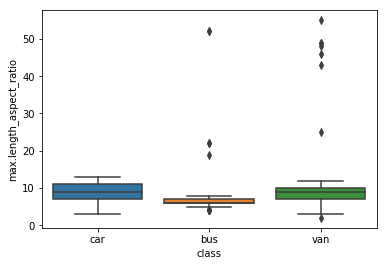

In [92]:
draw_boxplot("max.length_aspect_ratio")

In [93]:
# Let's grab the outliers from bus category.
outliers = grab_outliers_IQR(bus, "max.length_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85,44.0,70.0,205.0,88.5,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus
100,82,45.0,66.0,252.0,88.5,52,148.0,45.0,19.0,144,237.0,326.0,185.0,119.0,1.0,1.0,181.0,185,bus
127,85,41.0,66.0,155.0,65.0,22,149.0,45.0,19.0,139,173.0,330.0,155.0,75.0,6.0,16.0,184.0,191,bus
171,106,54.0,96.5,161.0,47.0,4,247.0,27.0,27.0,166,266.0,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
213,104,49.0,89.0,168.0,54.0,4,212.0,31.0,24.0,153,238.0,682.0,198.0,78.0,1.0,23.0,190.0,189,bus
375,109,52.0,95.0,189.0,58.0,4,227.0,29.0,25.0,158,262.0,776.0,217.0,82.0,0.0,19.0,187.0,186,bus
381,106,54.0,96.5,227.0,67.0,4,250.0,27.0,27.0,162,280.0,923.0,262.0,88.0,5.0,11.0,182.0,182,bus
444,102,53.0,96.5,238.0,72.0,4,238.0,28.0,26.0,163,267.0,844.0,242.0,85.0,7.0,22.0,184.0,184,bus
472,105,50.0,93.0,173.0,54.0,4,222.0,30.0,25.0,159,254.0,735.0,206.0,83.0,4.0,12.0,186.0,184,bus
544,88,43.0,70.0,177.0,74.0,19,152.0,44.0,19.0,143,180.0,342.0,168.0,76.0,1.0,9.0,186.0,189,bus


In [94]:
# Let's assess outliers from bus category. 
# Highlight other features that are 10% away from mean
consolidated = highlight_other_features(outliers, bus, "bus")
consolidated

In [95]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value

_, lower, upper = get_IQR(bus, 'max.length_aspect_ratio')

upper_list = outliers[outliers['max.length_aspect_ratio'] > upper].index.tolist()
vehicles.loc[upper_list, 'max.length_aspect_ratio'] = upper

lower_list = outliers[outliers['max.length_aspect_ratio'] < lower].index.tolist()
vehicles.loc[lower_list, 'max.length_aspect_ratio'] = lower

car, bus, van = refresh_datasets(vehicles)


In [96]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "max.length_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [97]:
# Let's grab the outliers from van category.
outliers = grab_outliers_IQR(van, "max.length_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90,48.0,86.0,198.75,76.0,49.0,153.0,44.0,19.0,156,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194,van
135,89,47.0,83.0,198.75,76.0,48.0,158.0,43.0,20.0,163,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194,van
291,89,45.0,81.0,198.75,76.0,43.0,155.0,44.0,20.0,160,200.0,347.0,177.0,90.0,9.0,17.0,183.0,192,van
388,94,47.0,85.0,198.75,76.0,49.0,155.0,43.0,19.0,155,320.0,354.0,187.0,135.0,12.0,9.0,188.0,196,van
391,91,38.0,70.0,160.00,66.0,25.0,140.0,47.0,18.0,139,162.0,296.0,130.0,67.0,4.0,11.0,192.0,202,van
523,90,43.0,81.0,198.75,76.0,46.0,150.0,45.0,19.0,149,200.0,332.0,164.0,91.0,5.0,9.0,186.0,196,van
655,86,35.0,44.0,110.00,54.0,2.0,119.0,57.0,17.0,121,139.0,208.0,137.0,90.0,6.0,1.0,180.0,183,van
706,82,43.0,70.0,198.75,76.0,55.0,139.0,48.0,18.0,145,231.0,289.0,172.0,99.0,4.0,9.0,190.0,199,van


In [98]:
# Let's assess outliers from van category. 
# Highlight other features that are 10% away from mean.
consolidated = highlight_other_features(outliers, van, "van")
consolidated

In [99]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(van, 'max.length_aspect_ratio')

upper_list = outliers[outliers['max.length_aspect_ratio'] > upper].index.tolist()
vehicles.loc[upper_list, 'max.length_aspect_ratio'] = upper

lower_list = outliers[outliers['max.length_aspect_ratio'] < lower].index.tolist()
vehicles.loc[lower_list, 'max.length_aspect_ratio'] = lower

car, bus, van = refresh_datasets(vehicles)

In [100]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "max.length_aspect_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [101]:
get_high_corrleation_features(vehicles, "max.length_aspect_ratio", THRESHOLD_CORR)
# Wov 9 other features are correlated

,max.length_aspect_ratio
distance_circularity,0.669033
max.length_rectangularity,0.633041
circularity,0.554403
radius_ratio,0.476004
compactness,0.471686
scatter_ratio,0.465375
pr.axis_rectangularity,0.461985
scaled_variance,0.426114
scaled_variance.1,0.425679


## scatter_ratio
1. Variable type: float64, continuous
2. 1 missing values
3. (inertia about minor axis)/(inertia about major axis) 

In [102]:
# Let's first locate the records with missing values
vehicles[vehicles['scatter_ratio'].isna()][['scatter_ratio', 'class']]
# 1 record [Index = 249] is for car 

,scatter_ratio,class
249,NaN,car


In [103]:
# Let's impute it with the mean values for the corresponding class
vehicles.loc[[249], 'scatter_ratio'] = car['scatter_ratio'].mean()

In [104]:
# Let's validate
vehicles.loc[[249]][['scatter_ratio', 'class']]

,scatter_ratio,class
249,181.053738,car


In [105]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

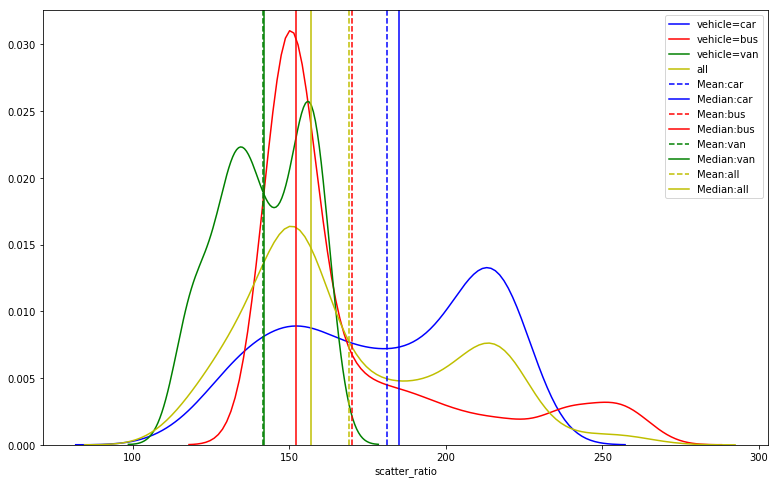

In [106]:
# Let's draw the plots
draw_distplot("scatter_ratio")

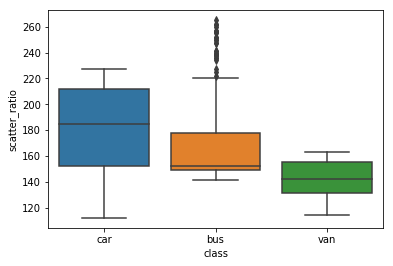

In [107]:
draw_boxplot("scatter_ratio")

In [108]:
# Let's grab the outliers from bus category.
outliers = grab_outliers_IQR(bus, "scatter_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,96.5,172.000000,50.0,6.0,255.0,26.0,28.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
54,101,54.500000,96.5,185.000000,53.0,6.0,257.0,26.0,28.0,168,275.0,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,54.500000,96.5,180.000000,51.0,6.0,261.0,26.0,28.0,171,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,96.5,223.000000,64.0,5.0,250.0,26.0,27.0,169,280.0,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,96.5,161.000000,47.0,4.5,247.0,27.0,27.0,166,266.0,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
193,107,54.500000,96.5,199.000000,59.0,7.0,240.0,27.0,26.0,168,258.0,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
274,107,54.500000,96.5,179.000000,51.0,8.0,257.0,26.0,28.0,172,275.0,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
294,109,54.500000,96.5,169.000000,51.0,6.0,241.0,27.0,26.0,165,265.0,870.0,247.0,84.0,10.0,11.0,184.0,183,bus
321,113,54.500000,96.5,194.000000,56.0,6.0,260.0,26.0,28.0,175,288.0,982.0,261.0,85.0,11.0,21.0,182.0,183,bus
334,107,54.500000,96.5,184.000000,55.0,7.0,234.0,28.0,26.0,171,243.0,822.0,229.0,77.0,7.0,11.0,187.0,187,bus


In [109]:
# Let's replace the outlier with upper whisker
_, lower, upper = get_IQR(bus, 'scatter_ratio')
vehicles.loc[outliers.index.tolist(), 'scatter_ratio'] = upper
car, bus, van = refresh_datasets(vehicles)

In [110]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scatter_ratio")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


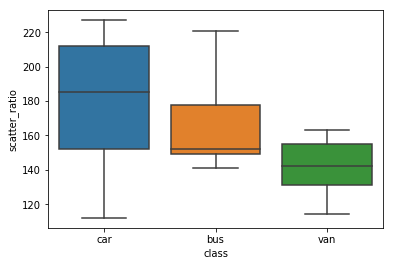

In [111]:
draw_boxplot("scatter_ratio")

In [112]:
get_high_corrleation_features(vehicles, "scatter_ratio", THRESHOLD_CORR)
# Wov 10 other features are correlated

,scatter_ratio
scaled_variance.1,0.977091
pr.axis_rectangularity,0.976418
scaled_variance,0.930273
distance_circularity,0.908496
circularity,0.851355
max.length_rectangularity,0.814027
compactness,0.811488
radius_ratio,0.800168
scaled_radius_of_gyration,0.783355
max.length_aspect_ratio,0.516954


## elongatedness
1. Variable type: float64, continuous
2. 1 missing values
3. area/(shrink width)**2 

In [113]:
# Let's first locate the records with missing values
vehicles[vehicles['elongatedness'].isna()][['elongatedness', 'class']]
# 1 record [Index = 215] is for car 

,elongatedness,class
215,NaN,car


In [114]:
vehicles.loc[215, 'elongatedness'] = car['elongatedness'].mean()

In [115]:
# Let's validate
vehicles.loc[215, 'elongatedness']

38.09345794392523

In [116]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

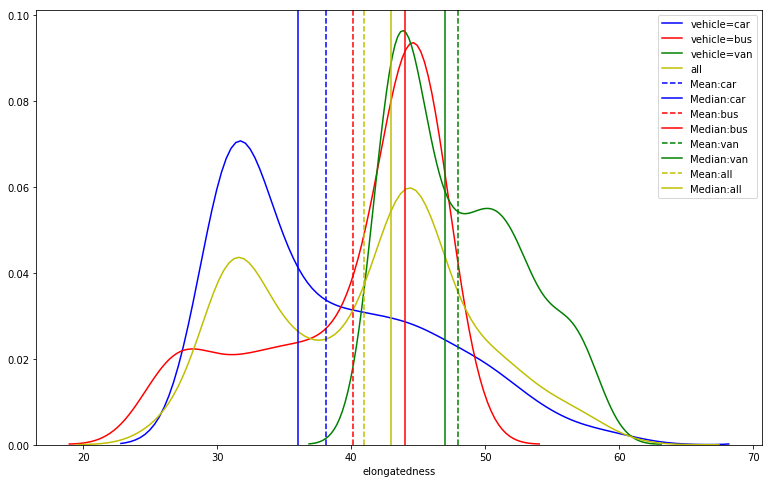

In [117]:
draw_distplot("elongatedness")

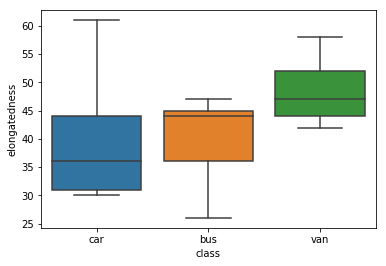

In [118]:
draw_boxplot("elongatedness")

1. car have pretty wide range of elongatedness; especially stretched in Q3 and Q4. Some cars have very high elongatedness (Upper whisker). Indicated by long right tail.
2. bus too have pretty wide elongatedness; especially in Q1 and Q2. This is indicated by long left tail. Q3 is pretty narrow hence showing peak in distplot.
3. van have higher elongatedness than car and bus. But the distribution is quite normal. Q3 & Q4 are more stretched compared to Q1 and Q2.

In [119]:
get_high_corrleation_features(vehicles, "elongatedness", THRESHOLD_CORR)

,elongatedness


1. Since it has zero features with which it correlates, we can keep elongatedness out of PCA Exercise

## pr.axis_rectangularity
1. Variable type: float64, continuous
2. 3 missing values
3. area/(pr.axis length*pr.axis width) 

In [120]:
# Let's first locate the records with missing values
vehicles[vehicles['pr.axis_rectangularity'].isna()][['pr.axis_rectangularity', 'class']]
# 1 record [Index = 70] is for car, 1 for bus and 1 for van

,pr.axis_rectangularity,class
70,NaN,car
237,NaN,bus
273,NaN,van


In [121]:
vehicles.loc[70, 'pr.axis_rectangularity'] = car['pr.axis_rectangularity'].mean()
vehicles.loc[237, 'pr.axis_rectangularity'] = bus['pr.axis_rectangularity'].mean()
vehicles.loc[273, 'pr.axis_rectangularity'] = van['pr.axis_rectangularity'].mean()

In [122]:
# Let's referesh
car, bus, van = refresh_datasets(vehicles)

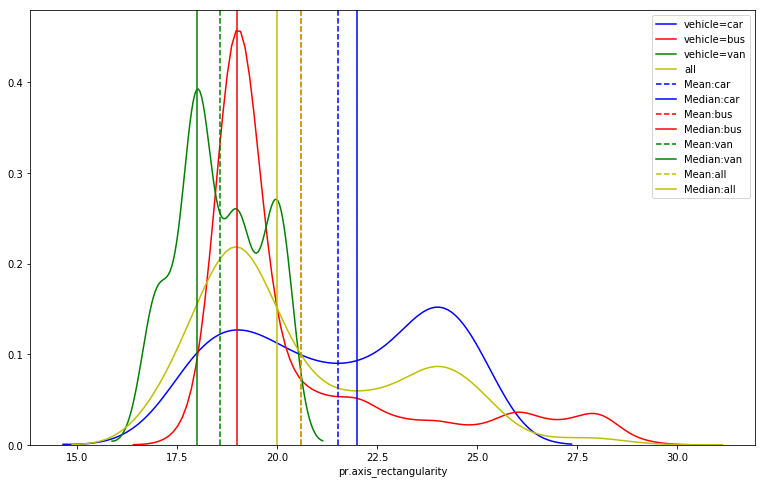

In [123]:
draw_distplot("pr.axis_rectangularity")

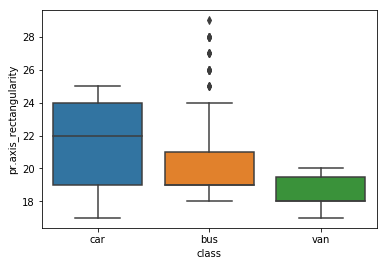

In [124]:
draw_boxplot("pr.axis_rectangularity")

In [125]:
outliers = grab_outliers_IQR(bus, "pr.axis_rectangularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,96.500000,172.000000,50.0,6.0,220.875,26.0,28.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
54,101,54.500000,96.500000,185.000000,53.0,6.0,220.875,26.0,28.0,168,275.0,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,54.500000,96.500000,180.000000,51.0,6.0,220.875,26.0,28.0,171,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,96.500000,223.000000,64.0,5.0,220.875,26.0,27.0,169,280.0,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,96.500000,161.000000,47.0,4.5,220.875,27.0,27.0,166,266.0,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
193,107,54.500000,96.500000,199.000000,59.0,7.0,220.875,27.0,26.0,168,258.0,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
274,107,54.500000,96.500000,179.000000,51.0,8.0,220.875,26.0,28.0,172,275.0,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
294,109,54.500000,96.500000,169.000000,51.0,6.0,220.875,27.0,26.0,165,265.0,870.0,247.0,84.0,10.0,11.0,184.0,183,bus
319,102,51.000000,76.767442,194.000000,60.0,6.0,220.000,30.0,25.0,162,247.0,731.0,209.0,80.0,7.0,7.0,188.0,186,bus
321,113,54.500000,96.500000,194.000000,56.0,6.0,220.875,26.0,28.0,175,288.0,982.0,261.0,85.0,11.0,21.0,182.0,183,bus


In [126]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'pr.axis_rectangularity')
vehicles.loc[outliers.index.tolist(), 'pr.axis_rectangularity'] = upper
car, bus, van = refresh_datasets(vehicles)

In [127]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "pr.axis_rectangularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [128]:
get_high_corrleation_features(vehicles, "pr.axis_rectangularity", THRESHOLD_CORR)
# Wov 10 other features are correlated

,pr.axis_rectangularity
scatter_ratio,0.987744
scaled_variance.1,0.965004
scaled_variance,0.907895
distance_circularity,0.906189
circularity,0.852199
max.length_rectangularity,0.821435
compactness,0.812546
radius_ratio,0.784637
scaled_radius_of_gyration,0.775121
max.length_aspect_ratio,0.539239


## max.length_rectangularity
1. Variable type: int64, continuous
2. 0 missing values
3. area/(max.length*length perp. to this)  

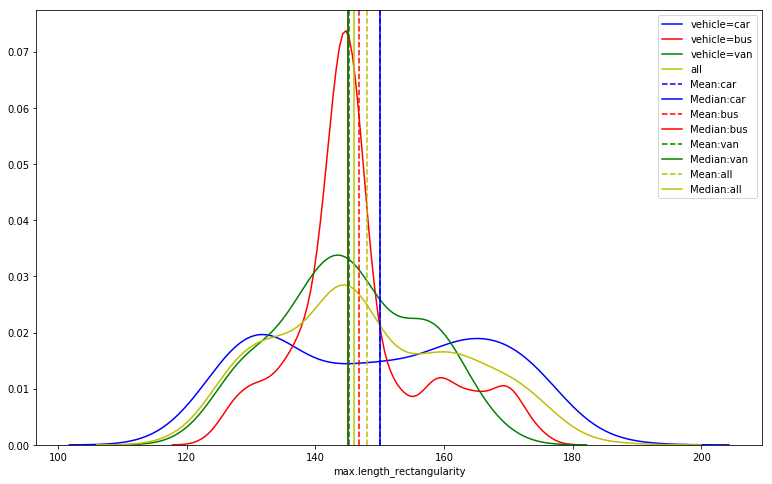

In [129]:
draw_distplot("max.length_rectangularity")

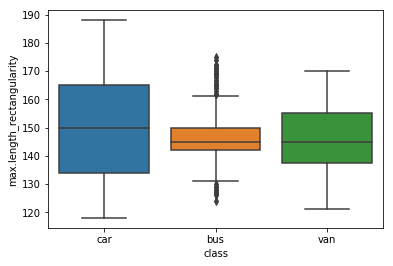

In [130]:
draw_boxplot("max.length_rectangularity")

In [131]:
outliers = grab_outliers_IQR(bus, "max.length_rectangularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,96.500000,172.000000,50.0,6.0,220.875,26.0,24.0,169,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
54,101,54.500000,96.500000,185.000000,53.0,6.0,220.875,26.0,24.0,168,275.0,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,54.500000,96.500000,180.000000,51.0,6.0,220.875,26.0,24.0,171,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,96.500000,223.000000,64.0,5.0,220.875,26.0,24.0,169,280.0,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,96.500000,161.000000,47.0,4.5,220.875,27.0,24.0,166,266.0,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
193,107,54.500000,96.500000,199.000000,59.0,7.0,220.875,27.0,24.0,168,258.0,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
236,96,37.000000,74.000000,199.000000,74.0,5.0,165.000,39.0,20.0,128,188.0,419.0,136.0,72.0,1.0,3.0,196.0,200,bus
246,95,36.000000,73.000000,191.000000,73.0,6.0,156.000,41.0,19.0,126,184.0,374.0,124.0,71.0,2.0,19.0,199.0,204,bus
274,107,54.500000,96.500000,179.000000,51.0,8.0,220.875,26.0,24.0,172,275.0,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
279,94,37.000000,73.000000,186.000000,71.0,7.0,154.000,42.0,19.0,127,171.0,362.0,132.0,67.0,2.0,8.0,197.0,206,bus


In [132]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(bus, 'max.length_rectangularity')

upper_list = outliers[outliers['max.length_rectangularity'] > upper].index.tolist()
vehicles.loc[upper_list, 'max.length_rectangularity'] = upper

lower_list = outliers[outliers['max.length_rectangularity'] < lower].index.tolist()
vehicles.loc[lower_list, 'max.length_rectangularity'] = lower

car, bus, van = refresh_datasets(vehicles)

In [133]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "max.length_rectangularity")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [134]:
get_high_corrleation_features(vehicles, "max.length_rectangularity", THRESHOLD_CORR)
# Wov 10 other features are correlated

,max.length_rectangularity
circularity,0.959478
scaled_radius_of_gyration,0.849523
pr.axis_rectangularity,0.816563
scatter_ratio,0.806347
scaled_variance.1,0.774394
distance_circularity,0.768933
scaled_variance,0.723620
compactness,0.666065
max.length_aspect_ratio,0.657414
radius_ratio,0.589221


## scaled_variance
1. Variable type: float64, continuous
2. 3 missing values
3. (2nd order moment about minor axis)/area ALONG MAJOR AXIS

In [135]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_variance'].isna()][['scaled_variance', 'class']]

,scaled_variance,class
105,NaN,car
372,NaN,van
522,NaN,car


In [136]:
# Let's fix
vehicles.loc[[105, 522], 'scaled_variance'] = car['scaled_variance'].mean()
vehicles.loc[[372], 'scaled_variance'] = van['scaled_variance'].mean()

In [137]:
# Let's validate
vehicles.loc[[105, 372, 522], 'scaled_variance']

105    197.894614
372    163.964646
522    197.894614
Name: scaled_variance, dtype: float64

In [138]:
car, bus, van = refresh_datasets(vehicles)

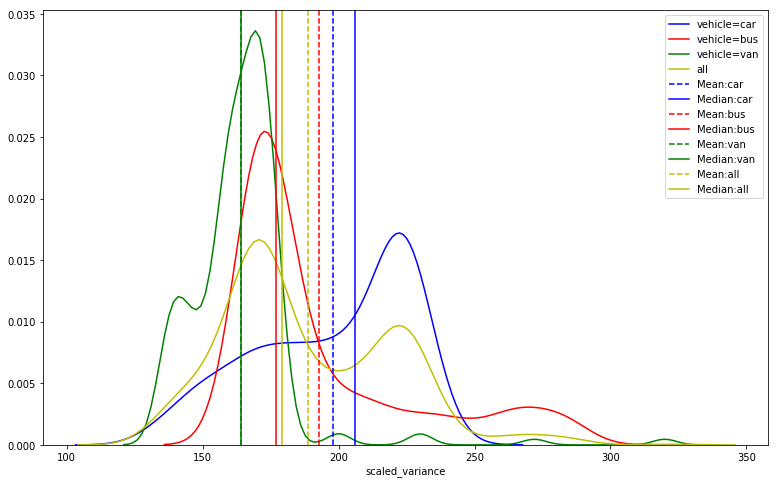

In [139]:
draw_distplot("scaled_variance")

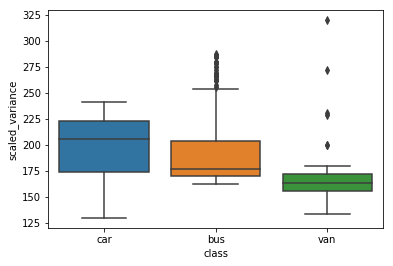

In [140]:
draw_boxplot("scaled_variance")

In [141]:
# Let's pull the outliers for bus
outliers = grab_outliers_IQR(bus, "scaled_variance")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,96.5,172.000000,50.0,6.0,220.875,26.0,24.0,161.375,280.0,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
54,101,54.500000,96.5,185.000000,53.0,6.0,220.875,26.0,24.0,161.375,275.0,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,54.500000,96.5,180.000000,51.0,6.0,220.875,26.0,24.0,161.375,278.0,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,96.5,223.000000,64.0,5.0,220.875,26.0,24.0,161.375,280.0,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,96.5,161.000000,47.0,4.5,220.875,27.0,24.0,161.375,266.0,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
193,107,54.500000,96.5,199.000000,59.0,7.0,220.875,27.0,24.0,161.375,258.0,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
274,107,54.500000,96.5,179.000000,51.0,8.0,220.875,26.0,24.0,161.375,275.0,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
294,109,54.500000,96.5,169.000000,51.0,6.0,220.875,27.0,24.0,161.375,265.0,870.0,247.0,84.0,10.0,11.0,184.0,183,bus
321,113,54.500000,96.5,194.000000,56.0,6.0,220.875,26.0,24.0,161.375,288.0,982.0,261.0,85.0,11.0,21.0,182.0,183,bus
345,101,54.000000,96.5,165.708333,57.0,7.0,220.875,28.0,24.0,161.375,256.0,833.0,253.0,81.0,6.0,14.0,185.0,185,bus


In [142]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'scaled_variance')
vehicles.loc[outliers.index.tolist(), 'scaled_variance'] = upper
car, bus, van = refresh_datasets(vehicles)

In [143]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_variance")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [144]:
# Let's pull the outliers for van
outliers = grab_outliers_IQR(van, "scaled_variance")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90,48.0,86.0,198.75,76.0,14.5,153.0,44.0,19.0,156.0,272.0,346.0,200.0,118.0,0.0,15.0,185.0,194,van
135,89,47.0,83.0,198.75,76.0,14.5,158.0,43.0,20.0,163.0,229.0,364.0,176.0,97.0,0.0,14.0,184.0,194,van
291,89,45.0,81.0,198.75,76.0,14.5,155.0,44.0,20.0,160.0,200.0,347.0,177.0,90.0,9.0,17.0,183.0,192,van
388,94,47.0,85.0,198.75,76.0,14.5,155.0,43.0,19.0,155.0,320.0,354.0,187.0,135.0,12.0,9.0,188.0,196,van
523,90,43.0,81.0,198.75,76.0,14.5,150.0,45.0,19.0,149.0,200.0,332.0,164.0,91.0,5.0,9.0,186.0,196,van
706,82,43.0,70.0,198.75,76.0,14.5,139.0,48.0,18.0,145.0,231.0,289.0,172.0,99.0,4.0,9.0,190.0,199,van


In [145]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(van, 'scaled_variance')
vehicles.loc[outliers.index.tolist(), 'scaled_variance'] = upper
car, bus, van = refresh_datasets(vehicles)

In [146]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "scaled_variance")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [147]:
get_high_corrleation_features(vehicles, "scaled_variance", THRESHOLD_CORR)
# Wov 9 other features are correlated

,scaled_variance
scaled_variance.1,0.964485
scatter_ratio,0.962731
pr.axis_rectangularity,0.943345
distance_circularity,0.874880
radius_ratio,0.814707
circularity,0.810705
compactness,0.783330
scaled_radius_of_gyration,0.782817
max.length_rectangularity,0.744765
max.length_aspect_ratio,0.438308


## scaled_variance.1
1. Variable type: float64, continuous
2. 2 missing values
3. (2nd order moment about major axis)/area ALONG MINOR AXIS

In [148]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_variance.1'].isna()][['scaled_variance.1', 'class']]

,scaled_variance.1,class
308,NaN,car
496,NaN,car


In [149]:
# Let's fix them
vehicles.loc[[308, 496], 'scaled_variance.1'] = car['scaled_variance.1'].mean()

In [150]:
# Let's validate
vehicles.loc[[308, 496], 'scaled_variance.1']

308    500.543326
496    500.543326
Name: scaled_variance.1, dtype: float64

In [151]:
car, bus, van = refresh_datasets(vehicles)

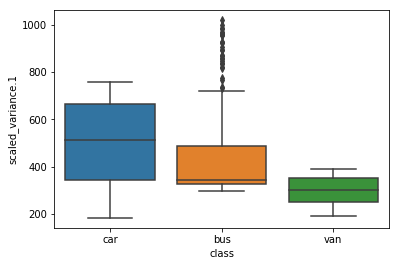

In [152]:
draw_boxplot("scaled_variance.1")

In [153]:
outliers = grab_outliers_IQR(bus, "scaled_variance.1")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,96.500000,172.000000,50.0,6.0,220.875,26.0,24.0,161.375,254.375,957.0,264.0,85.0,5.0,9.0,181.0,183,bus
54,101,54.500000,96.500000,185.000000,53.0,6.0,220.875,26.0,24.0,161.375,254.375,956.0,230.0,83.0,5.0,26.0,180.0,184,bus
85,110,54.500000,96.500000,180.000000,51.0,6.0,220.875,26.0,24.0,161.375,254.375,998.0,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,96.500000,223.000000,64.0,5.0,220.875,26.0,24.0,161.375,254.375,928.0,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,96.500000,161.000000,47.0,4.5,220.875,27.0,24.0,161.375,254.375,892.0,242.0,85.0,4.0,11.0,181.0,183,bus
193,107,54.500000,96.500000,199.000000,59.0,7.0,220.875,27.0,24.0,161.375,254.375,866.0,245.0,80.0,3.0,1.0,186.0,184,bus
274,107,54.500000,96.500000,179.000000,51.0,8.0,220.875,26.0,24.0,161.375,254.375,954.0,232.0,83.0,2.0,20.0,181.0,184,bus
294,109,54.500000,96.500000,169.000000,51.0,6.0,220.875,27.0,24.0,161.375,254.375,870.0,247.0,84.0,10.0,11.0,184.0,183,bus
319,102,51.000000,76.767442,194.000000,60.0,6.0,220.000,30.0,24.0,161.375,247.000,731.0,209.0,80.0,7.0,7.0,188.0,186,bus
321,113,54.500000,96.500000,194.000000,56.0,6.0,220.875,26.0,24.0,161.375,254.375,982.0,261.0,85.0,11.0,21.0,182.0,183,bus


In [154]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'scaled_variance.1')
vehicles.loc[outliers.index.tolist(), 'scaled_variance.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [155]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_variance.1")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


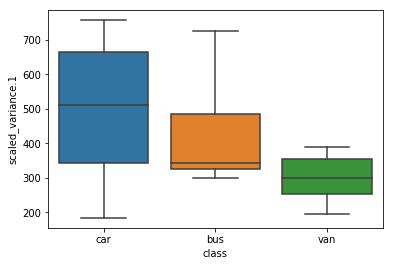

In [156]:
draw_boxplot("scaled_variance.1")

In [157]:
get_high_corrleation_features(vehicles, "scaled_variance.1", THRESHOLD_CORR)
# Wov there are 10 correlated features

,scaled_variance.1
scatter_ratio,0.994427
pr.axis_rectangularity,0.988478
scaled_variance,0.962703
distance_circularity,0.900084
circularity,0.849130
compactness,0.822374
max.length_rectangularity,0.800609
radius_ratio,0.798690
scaled_radius_of_gyration,0.782236
max.length_aspect_ratio,0.493269


## scaled_radius_of_gyration
1. Variable type: float64, continuous
2. 2 missing values
3. (mavar+mivar)/area

In [158]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_radius_of_gyration'].isna()][['scaled_radius_of_gyration', 'class']]

,scaled_radius_of_gyration,class
207,NaN,bus
266,NaN,bus


In [159]:
vehicles.loc[[207, 266], 'scaled_radius_of_gyration'] = bus['scaled_radius_of_gyration'].mean()

In [160]:
# Let's validate
vehicles.loc[[207, 266], 'scaled_radius_of_gyration']

207    181.032407
266    181.032407
Name: scaled_radius_of_gyration, dtype: float64

In [161]:
car, bus, van = refresh_datasets(vehicles)

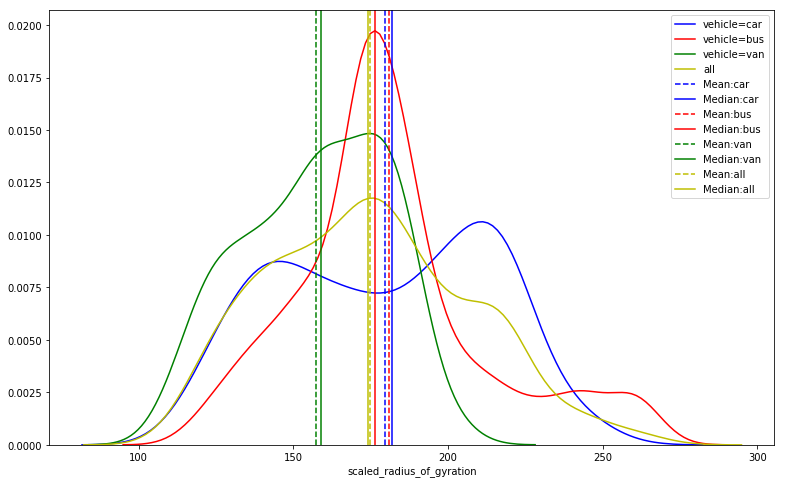

In [162]:
draw_distplot('scaled_radius_of_gyration')

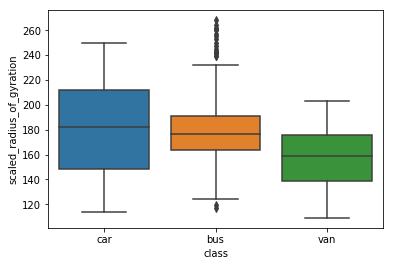

In [163]:
draw_boxplot('scaled_radius_of_gyration')

In [164]:
outliers = grab_outliers_IQR(bus, 'scaled_radius_of_gyration')
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
5,107,44.981308,96.5,172.000000,50.0,6.0,220.875,26.0,24.0,161.375,254.375,725.75,264.0,85.0,5.0,9.0,181.0,183,bus
85,110,54.500000,96.5,180.000000,51.0,6.0,220.875,26.0,24.0,161.375,254.375,725.75,257.0,83.0,9.0,13.0,181.0,182,bus
155,110,54.500000,96.5,223.000000,64.0,5.0,220.875,26.0,24.0,161.375,254.375,725.75,239.0,85.0,4.0,6.0,184.0,183,bus
171,106,54.000000,96.5,161.000000,47.0,4.5,220.875,27.0,24.0,161.375,254.375,725.75,242.0,85.0,4.0,11.0,181.0,183,bus
193,107,54.500000,96.5,199.000000,59.0,7.0,220.875,27.0,24.0,161.375,254.375,725.75,245.0,80.0,3.0,1.0,186.0,184,bus
294,109,54.500000,96.5,169.000000,51.0,6.0,220.875,27.0,24.0,161.375,254.375,725.75,247.0,84.0,10.0,11.0,184.0,183,bus
321,113,54.500000,96.5,194.000000,56.0,6.0,220.875,26.0,24.0,161.375,254.375,725.75,261.0,85.0,11.0,21.0,182.0,183,bus
345,101,54.000000,96.5,165.708333,57.0,7.0,220.875,28.0,24.0,161.375,254.375,725.75,253.0,81.0,6.0,14.0,185.0,185,bus
381,106,54.000000,96.5,227.000000,67.0,4.5,220.875,27.0,24.0,161.375,254.375,725.75,262.0,88.0,5.0,11.0,182.0,182,bus
396,108,44.981308,96.5,177.000000,51.0,5.0,220.875,26.0,24.0,161.375,254.375,725.75,261.0,87.0,11.0,2.0,182.0,181,bus


In [165]:
# There are two types of outliers. One that fall below lower whisker which can be replaced by lower whisker value
# and other that fall above upper whisker which can be replaced by upper whisker value
_, lower, upper = get_IQR(bus, 'scaled_radius_of_gyration')

upper_list = outliers[outliers['scaled_radius_of_gyration'] > upper].index.tolist()
vehicles.loc[upper_list, 'scaled_radius_of_gyration'] = upper

lower_list = outliers[outliers['scaled_radius_of_gyration'] < lower].index.tolist()
vehicles.loc[lower_list, 'scaled_radius_of_gyration'] = lower

car, bus, van = refresh_datasets(vehicles)

In [166]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_radius_of_gyration")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [167]:
get_high_corrleation_features(vehicles, "scaled_radius_of_gyration", THRESHOLD_CORR)
# Wov 10 correlated features

,scaled_radius_of_gyration
circularity,0.934013
max.length_rectangularity,0.862213
scatter_ratio,0.783445
scaled_variance.1,0.780715
pr.axis_rectangularity,0.777854
scaled_variance,0.774577
distance_circularity,0.693798
compactness,0.578211
radius_ratio,0.563367
max.length_aspect_ratio,0.415027


## scaled_radius_of_gyration.1
1. Variable type: float64, continuous
2. 4 missing values

In [168]:
# Let's first locate the records with missing values
vehicles[vehicles['scaled_radius_of_gyration.1'].isna()][['scaled_radius_of_gyration.1', 'class']]

,scaled_radius_of_gyration.1,class
66,NaN,bus
77,NaN,car
192,NaN,car
329,NaN,car


In [169]:
vehicles.loc[[66], 'scaled_radius_of_gyration.1'] = bus['scaled_radius_of_gyration.1'].mean()
vehicles.loc[[77, 192, 329], 'scaled_radius_of_gyration.1'] = car['scaled_radius_of_gyration.1'].mean()

In [170]:
# Let's validate
vehicles.loc[[66, 77, 192, 329], 'scaled_radius_of_gyration.1']

66     77.096774
77     69.924883
192    69.924883
329    69.924883
Name: scaled_radius_of_gyration.1, dtype: float64

In [171]:
car, bus, van = refresh_datasets(vehicles)

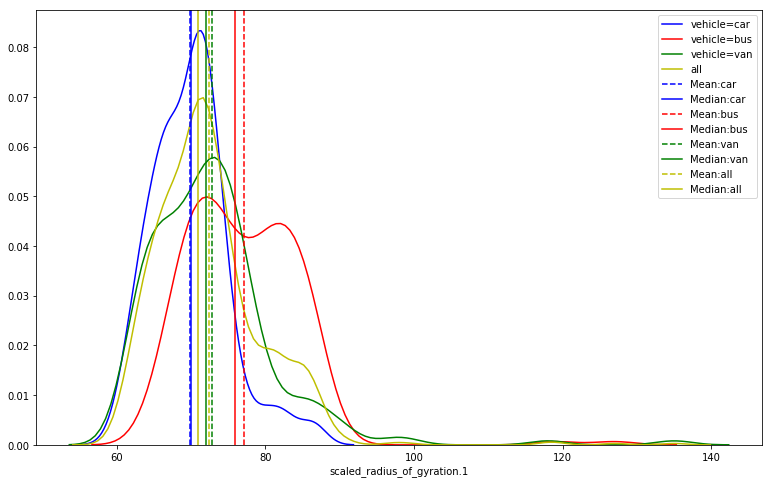

In [172]:
draw_distplot('scaled_radius_of_gyration.1')

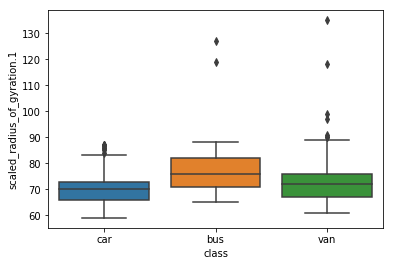

In [173]:
draw_boxplot("scaled_radius_of_gyration.1")

In [174]:
# Let's grab the outliers for car
outliers = grab_outliers_IQR(car, 'scaled_radius_of_gyration.1')
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
160,82,38.0,53.0,125.0,59.0,5.0,133.0,51.0,18.0,128.0,152.0,259.0,146.0,87.0,0.0,0.0,177.0,183,car
231,85,33.0,40.0,115.0,57.0,3.0,112.0,61.0,17.0,119.0,130.0,184.0,127.0,86.0,12.0,21.0,181.0,183,car
342,83,37.0,54.0,131.0,61.0,4.0,135.0,50.0,18.0,127.0,152.0,271.0,141.0,85.0,3.0,6.0,180.0,183,car
351,88,38.0,58.0,137.0,60.0,5.0,148.0,46.0,19.0,131.0,163.0,319.0,157.0,86.0,12.0,0.0,180.0,183,car
411,78,36.0,51.0,116.0,56.0,4.0,120.0,57.0,17.0,124.0,135.0,209.0,135.0,84.0,1.0,12.0,177.0,184,car
463,85,40.0,66.0,121.0,52.0,4.0,152.0,44.0,19.0,133.0,170.0,340.0,163.0,87.0,13.0,3.0,180.0,183,car
515,76,38.0,58.0,125.0,58.0,5.0,133.0,51.0,18.0,127.0,152.0,259.0,145.0,87.0,0.0,21.0,177.0,184,car
612,80,34.0,42.0,110.0,57.0,3.0,114.0,59.0,17.0,119.0,131.0,191.0,121.0,87.0,4.0,7.0,179.0,183,car
834,82,36.0,51.0,114.0,53.0,4.0,135.0,50.0,18.0,126.0,150.0,268.0,144.0,86.0,15.0,4.0,181.0,182,car


In [175]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(car, 'scaled_radius_of_gyration.1')
vehicles.loc[outliers.index.tolist(), 'scaled_radius_of_gyration.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [176]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(car, "scaled_radius_of_gyration.1")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [177]:
# Let's grab the outliers for bus
outliers = grab_outliers_IQR(bus, 'scaled_radius_of_gyration.1')
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
4,85,44.0,70.0,205.0,88.5,8.5,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus
100,82,45.0,66.0,252.0,88.5,8.5,148.0,45.0,19.0,144.0,237.0,326.0,185.0,119.0,1.0,1.0,181.0,185,bus


In [178]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(bus, 'scaled_radius_of_gyration.1')
vehicles.loc[outliers.index.tolist(), 'scaled_radius_of_gyration.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [179]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(bus, "scaled_radius_of_gyration.1")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


In [180]:
# Let's grab the outliers for van
outliers = grab_outliers_IQR(van, 'scaled_radius_of_gyration.1')
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
37,90,48.0,86.0,198.75,76.0,14.5,153.0,44.0,19.0,156.0,196.0,346.0,200.0,118.0,0.0,15.0,185.0,194,van
135,89,47.0,83.0,198.75,76.0,14.5,158.0,43.0,20.0,163.0,196.0,364.0,176.0,97.0,0.0,14.0,184.0,194,van
291,89,45.0,81.0,198.75,76.0,14.5,155.0,44.0,20.0,160.0,196.0,347.0,177.0,90.0,9.0,17.0,183.0,192,van
388,94,47.0,85.0,198.75,76.0,14.5,155.0,43.0,19.0,155.0,196.0,354.0,187.0,135.0,12.0,9.0,188.0,196,van
523,90,43.0,81.0,198.75,76.0,14.5,150.0,45.0,19.0,149.0,196.0,332.0,164.0,91.0,5.0,9.0,186.0,196,van
655,86,35.0,44.0,110.00,54.0,2.5,119.0,57.0,17.0,121.0,139.0,208.0,137.0,90.0,6.0,1.0,180.0,183,van
706,82,43.0,70.0,198.75,76.0,14.5,139.0,48.0,18.0,145.0,196.0,289.0,172.0,99.0,4.0,9.0,190.0,199,van


In [181]:
# Let's replace these outliers with upper whisker
_, lower, upper = get_IQR(van, 'scaled_radius_of_gyration.1')
vehicles.loc[outliers.index.tolist(), 'scaled_radius_of_gyration.1'] = upper
car, bus, van = refresh_datasets(vehicles)

In [182]:
# Let's check if outliers have been removed
outliers = grab_outliers_IQR(van, "scaled_radius_of_gyration.1")
outliers

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class


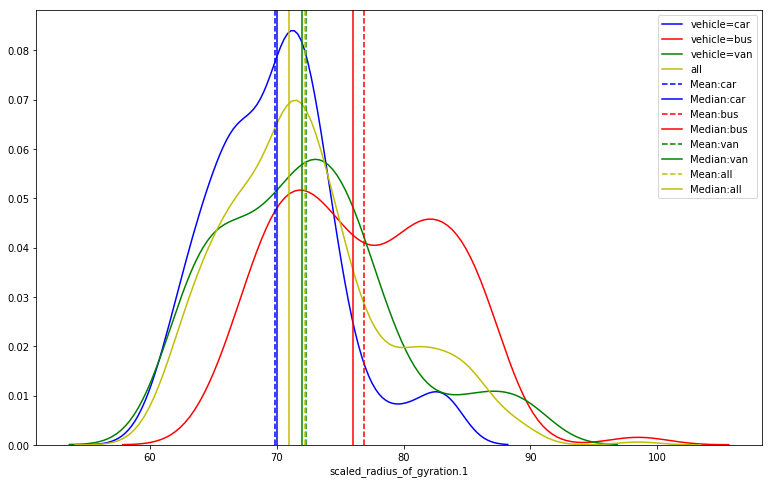

In [184]:
draw_distplot('scaled_radius_of_gyration.1')

In [183]:
get_high_corrleation_features(vehicles, 'scaled_radius_of_gyration.1', THRESHOLD_CORR)

,scaled_radius_of_gyration.1


1. Since 'scaled_radius_of_gyration.1' doesn't have any correlation, it can be skipped from PCA

## skewness_about